In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR='/data/train'
TEST_DIR='/data/test'
train_data_numpy = '/data/train_data.npy'
test_data_numpy = '/data/test_data.npy'
IMG_SIZE=50
LR=1e-3
MODEL_NAME='test_model'

In [2]:
def  label_image(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat':
        return [1,0]
    elif word_label == 'dog':
        return [0, 1]

In [3]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_image(img)
        path= os.path.join(TRAIN_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    np.save('/data/train_data.npy', training_data)
    return training_data
        

In [4]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path= os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img), img_num])
    np.save('/data/test_data.npy', testing_data)
    return testing_data

In [5]:
if os.path.exists(train_data_numpy):
    train_data = np.load(train_data_numpy)
else:
    train_data = create_train_data()

100%|██████████| 25000/25000 [01:16<00:00, 328.34it/s]


In [6]:
import tflearn

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)


In [7]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()

# Building convolutional convnet
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')
# http://tflearn.org/layers/conv/
# http://tflearn.org/activations/
convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)


convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')




In [8]:
train = train_data[:-500]
test = train_data[-500:]

In [9]:
(train[1][0].reshape(-1,IMG_SIZE,IMG_SIZE,1)).shape

(1, 50, 50, 1)

In [10]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE, IMG_SIZE, 1)

Y = np.array([i[1] for i in train])

In [11]:
test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE, IMG_SIZE, 1)

test_y = np.array([i[1] for i in test])

In [12]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 0.53858 | time: 124.321s
| Adam | epoch: 003 | loss: 0.53858 - acc: 0.7332 -- iter: 24448/24500
Training Step: 1149  | total loss: 0.54062 | time: 125.255s
| Adam | epoch: 003 | loss: 0.54062 - acc: 0.7271 | val_loss: 0.57846 - val_acc: 0.6860 -- iter: 24500/24500
--


In [13]:
model.save(MODEL_NAME)

INFO:tensorflow:/notebooks/test_model is not in all_model_checkpoint_paths. Manually adding it.


In [14]:
import matplotlib.pyplot as plt

if os.path.exists(test_data_numpy):
    test_data = np.load(test_data_numpy)
else:
    test_data = process_test_data()

ImportError: No module named matplotlib.pyplot

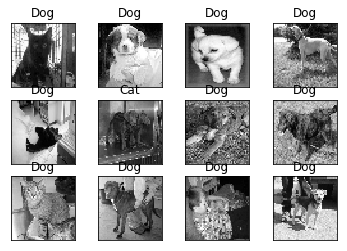

In [39]:
fig  = plt.figure()

for num, data in enumerate(test_data[40:52]):
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3, 4, num + 1)
    
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label = 'Dog'
    else: str_label = 'Cat'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()


In [46]:
with open('/data/submission-file.csv' ,  'w') as f:
    f.write('id,label\n')
    

In [47]:
with open('/data/submission-file.csv' ,  'a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]

        orig = img_data
        data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)

        model_out = model.predict([data])[0]
        
        f.write(img_num + ',' + str(model_out[1]) + '\n')

    

100%|██████████| 12500/12500 [00:17<00:00, 713.82it/s]
